### Install cellpose  

In [4]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

* Check CUDA version and that GPU is working in cellpose and import other libraries.

In [5]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Thu Mar 21 13:13:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              29W /  7

### Mount google drive
(Only execute this cell if you're using your own images)

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Download sample images (optional)

If you don't mount your google drive, and want to test cellpose 2.0, run the next code block to download the example data. This `human_in_the_loop` folder has a `train` folder with training images and manual segmentations (in this case created in the loop), and a `test` folder with test images and manual segmentations from scratch.

These images are from the breast vectra class from the Tissuenet dataset. The full Tissuenet dataset is available [here](https://datasets.deepcell.org/).

In [7]:
from natsort import natsorted
url = 'https://drive.google.com/uc?id=1HXpLczf7TPCdI1yZY5KV3EkdWzRrgvhQ'
utils.download_url_to_file(url, 'human_in_the_loop.zip')

!unzip human_in_the_loop
train_files = natsorted(glob('human_in_the_loop/train/*.tif'))
train_seg = natsorted(glob('human_in_the_loop/train/*.npy'))

test_files = natsorted(glob('human_in_the_loop/test/*.npy'))
test_seg = natsorted(glob('human_in_the_loop/test/*.npy'))

100%|██████████| 15.5M/15.5M [00:00<00:00, 31.7MB/s]


Archive:  human_in_the_loop.zip
   creating: human_in_the_loop/test/
  inflating: human_in_the_loop/test/breast_vectra_0.tif  
  inflating: human_in_the_loop/test/breast_vectra_0_seg.npy  
  inflating: human_in_the_loop/test/img_1213.tif  
  inflating: human_in_the_loop/test/img_1213_seg.npy  
  inflating: human_in_the_loop/test/img_1220.tif  
  inflating: human_in_the_loop/test/img_1220_seg.npy  
   creating: human_in_the_loop/train/
  inflating: human_in_the_loop/train/img_0.tif  
  inflating: human_in_the_loop/train/img_0_seg.npy  
  inflating: human_in_the_loop/train/img_1.tif  
  inflating: human_in_the_loop/train/img_1_seg.npy  
  inflating: human_in_the_loop/train/img_3.tif  
  inflating: human_in_the_loop/train/img_3_seg.npy  
  inflating: human_in_the_loop/train/img_4.tif  
  inflating: human_in_the_loop/train/img_4_seg.npy  
  inflating: human_in_the_loop/train/img_5.tif  
  inflating: human_in_the_loop/train/img_5_seg.npy  


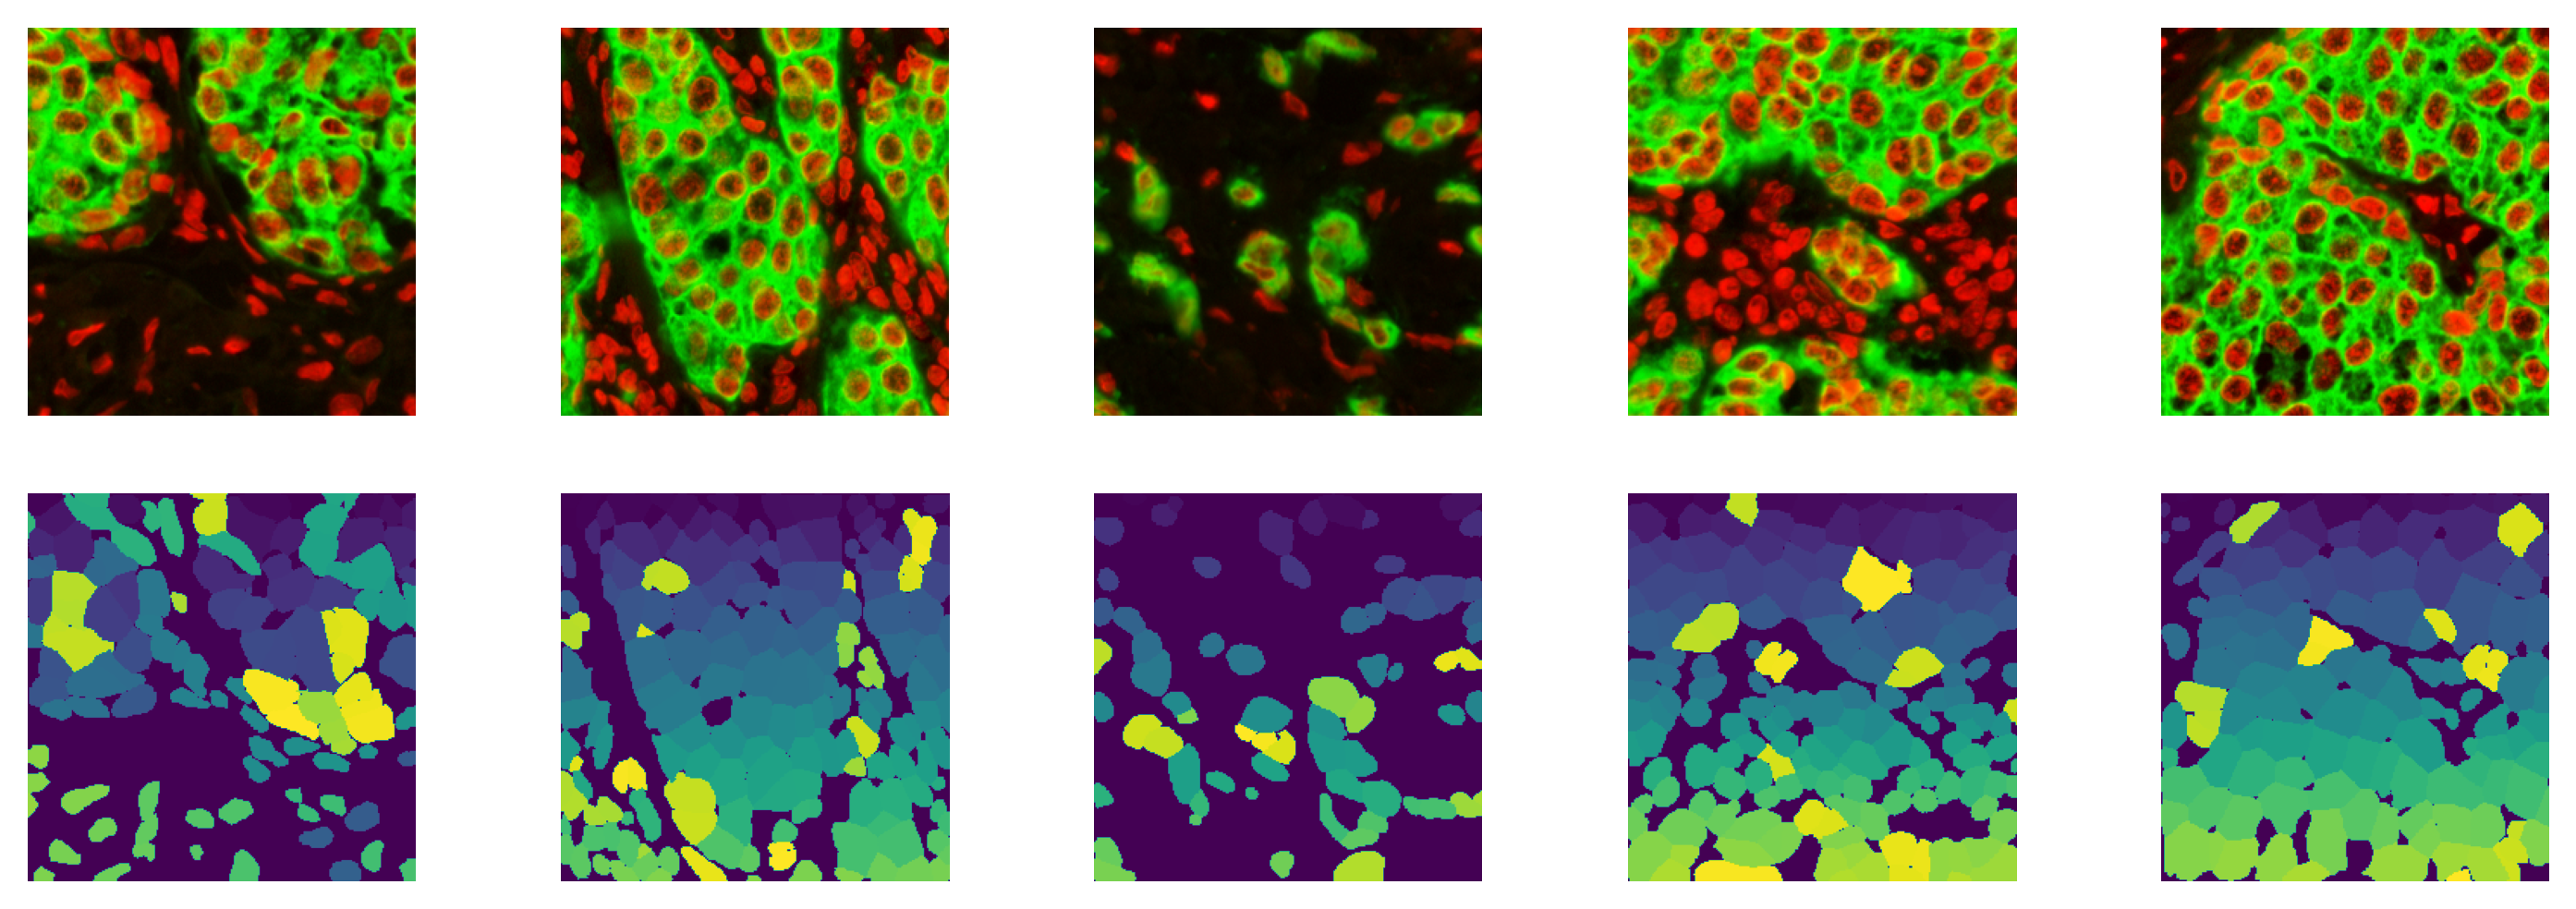

In [8]:
plt.figure(figsize=(12,4), dpi=300)
for k,f in enumerate(train_files):
    img = io.imread(f)
    plt.subplot(2,len(train_files),k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(2,len(train_files),len(train_files) + k+1)
    seg = np.load(os.path.splitext(f)[0] + '_seg.npy', allow_pickle=True).item()
    masks= seg['masks'].squeeze()
    plt.imshow(masks)
    plt.axis('off')

### Train model on manual annotations
(To train a new model, please fill out the form below with the paths to your data and the desired training parameters.)

In [13]:
#@markdown ###Path to images and masks:

train_dir = "human_in_the_loop/train" #@param {type:"string"}
test_dir = "human_in_the_loop/test" #@param {type:"string"}
#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_tissuenet" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


### Train new model

In [14]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

100%|██████████| 3/3 [00:00<00:00, 1763.79it/s]


### Evaluate Model

In [15]:
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

masks = model.eval(test_data,
                    channels=[chan, chan2],
                    diameter=diam_labels)[0]

# check performance
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


>>> average precision at iou threshold 0.5 = 0.620


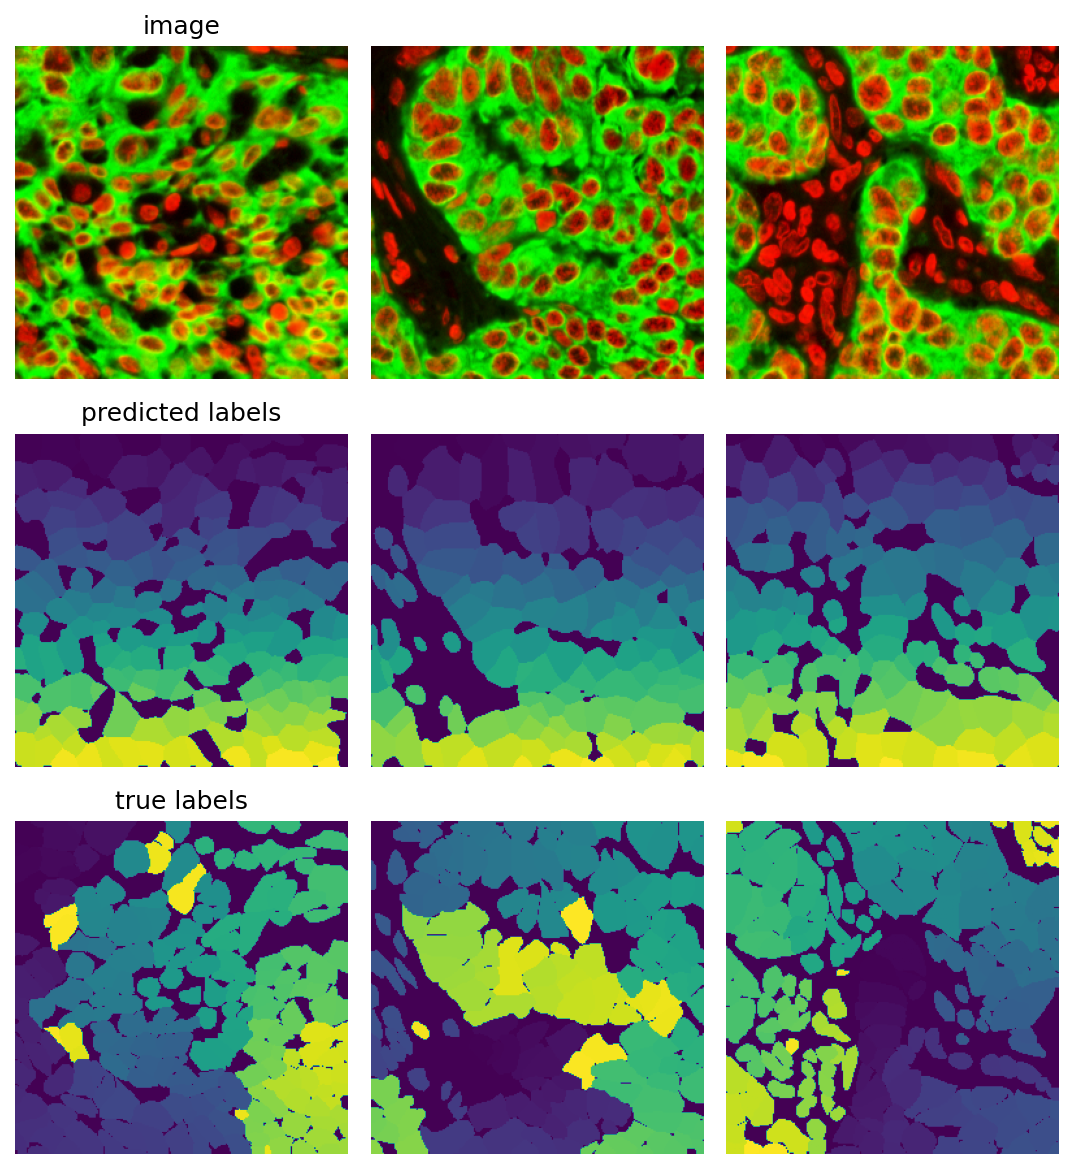

In [16]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_files), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_files), len(train_files) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_files), 2*len(train_files) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

### Custom Model  
Take custom trained model from above, or upload your own model to google drive / colab runtime.

In [18]:
# model name and path

#@markdown ###Custom model path (full path):

model_path = "human_in_the_loop/train/models/CP_tissuenet" #@param {type:"string"}

#@markdown ###Path to images:

dir = "human_in_the_loop/test" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}


In [19]:
src = 'human_in_the_loop/test'
if dir[:len(src)] == src:
    files = io.get_image_files(dir, '_masks')
    dir = 'human_in_the_loop/eval/'
    os.makedirs(dir, exist_ok=True)
    for f in files:
        dst = dir + os.path.split(f)[1]
        print(f'{f} > {dst}')
        shutil.copyfile(f, dst)

human_in_the_loop/test/breast_vectra_0.tif > human_in_the_loop/eval/breast_vectra_0.tif
human_in_the_loop/test/img_1213.tif > human_in_the_loop/eval/img_1213.tif
human_in_the_loop/test/img_1220.tif > human_in_the_loop/eval/img_1220.tif


In [20]:
# Run the Custom Model
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

masks, flows, styles = model.eval(images,
                                    channels=[chan, chan2],
                                    diameter=diameter,
                                    flow_threshold=flow_threshold,
                                    cellprob_threshold=cellprob_threshold)

['human_in_the_loop/eval/breast_vectra_0.tif', 'human_in_the_loop/eval/img_1213.tif', 'human_in_the_loop/eval/img_1220.tif']


### Save output to *_seg.npy


In [21]:
from cellpose import io

io.masks_flows_to_seg(images,
                        masks,
                        flows,
                        files,
                        channels=[chan, chan2],
                        diams=diameter*np.ones(len(masks)))

### Save output Masks  

In [23]:
io.save_masks(images,
                masks,
                flows,
                files,
                channels=[chan, chan2],
                png=True, # save masks as PNGs
                tif=True, # save masks as TIFFs
                save_txt=True, # save txt outlines for ImageJ
                save_flows=False, # save flows as TIFFs
                save_outlines=False, # save outlines as TIFFs
                save_mpl=True) # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES))

(-0.5, 3599.5, 899.5, -0.5)

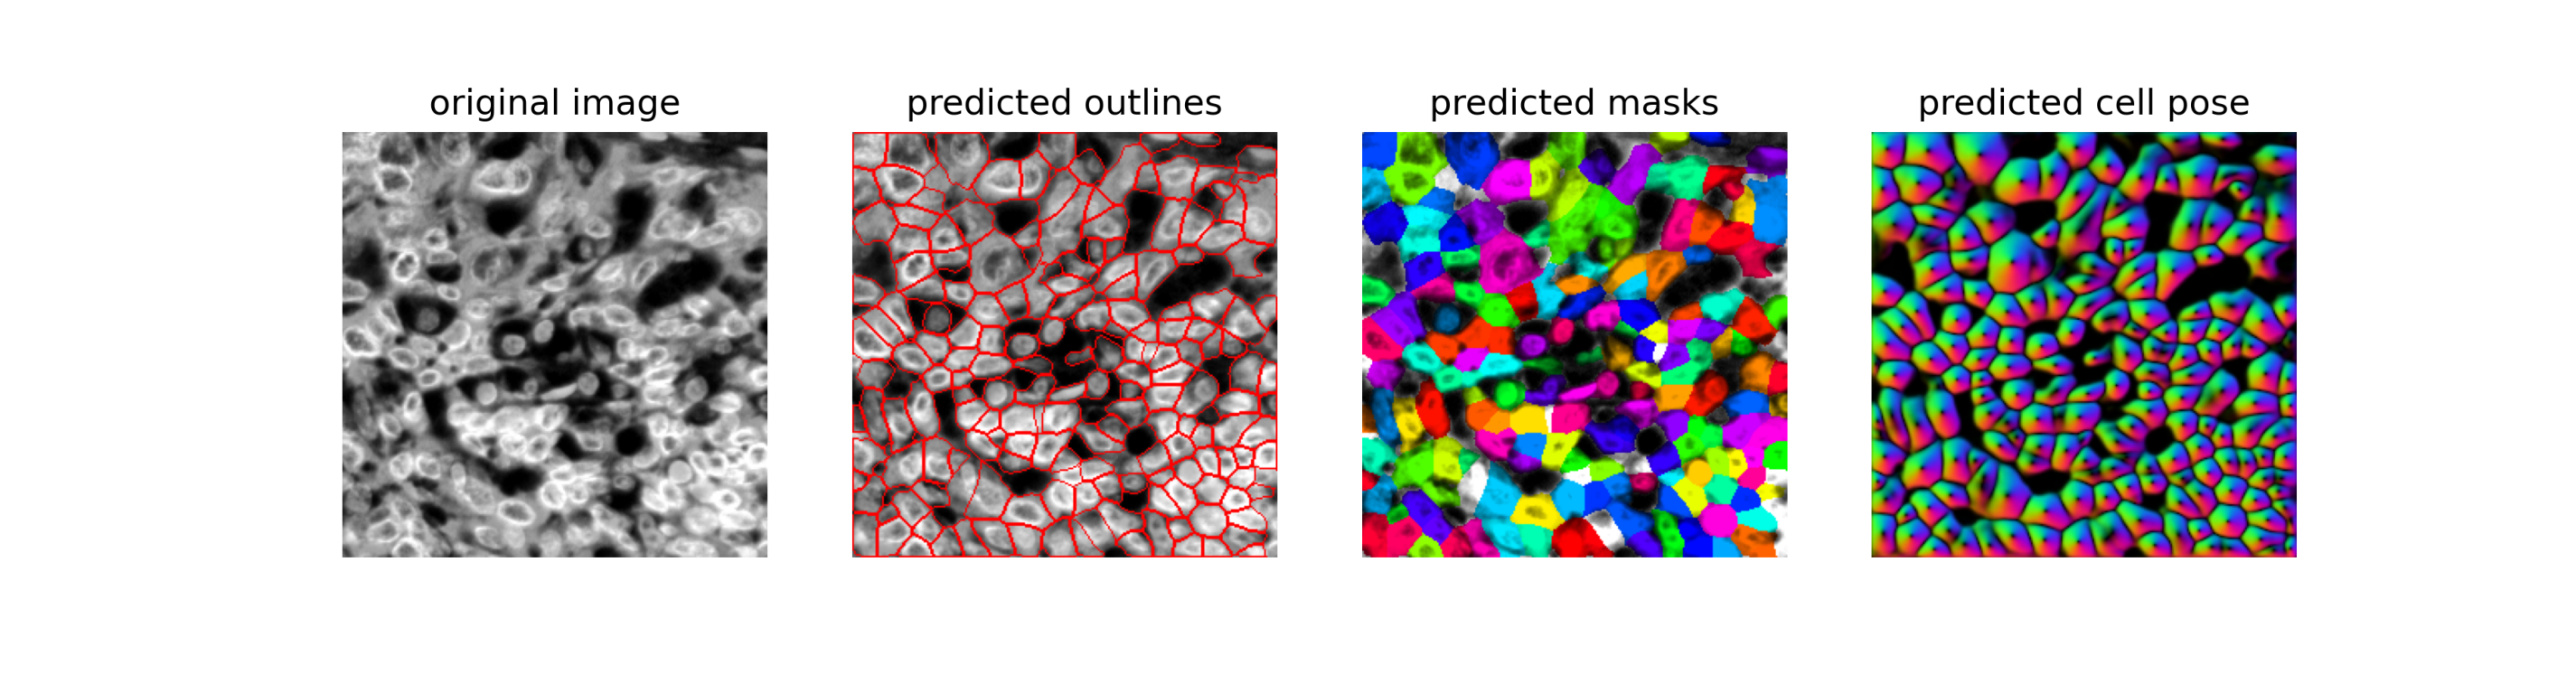

In [24]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')